In [38]:
# Importing modules / libs
from pdf2image import convert_from_path
import os
import requests
import base64
import json
from openai import AzureOpenAI
import time
import yaml

ModuleNotFoundError: No module named 'pandas'

In [34]:
# Loading yaml config file

with open("config.yaml", 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [13]:
# Reading the pdf files from sample_data directory
# List files in directory
files: list[str] = os.listdir('sample_data')
invoices: list[dict]= []


# Loop through files
for file in files:
    print(file)
    fileName = file.split(".")[0]
    invoiceImage = convert_from_path('sample_data/'+file, 400)

    # Save pages as images in the pdf
    fileOutputPath = f'output_data/{fileName}.jpg'
    invoiceImage[0].save(fileOutputPath, 'JPEG')

    invoices.append({
        "fileName":fileName,
        "path": fileOutputPath
    })




NF_001.pdf
NF_002.pdf
NF_003.pdf
NF_004.pdf
NF_005.pdf
NF_34181.pdf


In [46]:
# Metrics metadata

usage_details: dict = {
    "GPT4 Vision" : None,
    "GPT4o" : None,
    #"GPT 3.5 Function calling": None,
    #"GPT 3.5 Completion": None,
    "Gemini": None,
    "Anthropic": None,
}

# Content data
completions_results: list[dict] = []

# 1.0 Prompt Engineering

In [15]:
# Expected result format
result_output: str = """
{
                  numero_nf:,
                  data_hora_emissao:,
                  codigo_verificacao:,
                  prestador: {
                    razao_social: ,
                    cpf_cnpj: ,
                    insc_municipal: ,
                    endereco: ,
                    municipio: ,
                    uf: ,
                    email:,
                    telefone: ,

                  },
                  tomador: {
                    razao_social: ,
                    cpf_cnpj: ,
                    insc_municipal: ,
                    endereco: ,
                    municipio: ,
                    uf: ,
                    email:,
                    telefone: ,

                  },
                  discrim_servico:,
                  vlr_liquido:,
                  vlr_tot_nf:,
                  deduc_base_calc_issqn:,
                  base_calculo issqn:,
                  aliq_issqn:,
                  issqn_dev:,
                  cnae:,
                  desc_ativ:,
                  servico:,
                  pis:,
                  cofins:,
                  inss:,
                  ir:,
                  csll:,
                  data_venc_issqn:,
                  item_lei_116:,
              }
"""

In [16]:
systemMessage: str = """
You are an AI assistant in Brazilian fiscal area. The CNPJ fields must contain only 14 digits only.
The format of the CNPJ will always be the following: XX.XXX.XXX/XXXX-XX. Be aware to not mess it.
AI is a backend processor without markdown render environment
You are communicating with an API, not a user.
Begin all AI responses with the character ‘{’ to produce valid JSON
"""

mainPrompt: str = f"""
Show me the content of this document in JSON format. Then, Based on the description, add a field: 'Item da Lei 116' with the best suited code.
The JSON must be in the following format:
{result_output}
"""

# 2.0 Auxiliary methods

In [17]:
def getCNPJStatus(CNPJ: str):
  CNPJ = CNPJ.replace('.','').replace('-','').replace('/','')
  print(f'Looking for {CNPJ}')
  data = requests.get(f"https://publica.cnpj.ws/cnpj/{CNPJ}")

  data = json.loads(data.text)
  finalResult: dict = {
      "situacao": data['estabelecimento']['situacao_cadastral'],
      "tipoempresa": data['simples']
  }

  if finalResult['tipoempresa'] is None:
    finalResult['tipoempresa'] = 'Lucro presumido'
  else:
    if finalResult['tipoempresa']['simples'] == 'Sim':
      finalResult['tipoempresa'] = 'Simples nacional'
    else:
      finalResult['tipoempresa'] = 'MEI'


  return json.dumps(finalResult)

# 3.0a GPT4 Vision

In [47]:
# Configuration
GPT4V_KEY = config["azopenaiGPT4Vision"]["token"]
RESOURCE_NAME = config["azopenaiGPT4Vision"]["resource_name"]
API_VERSION = config["azopenaiGPT4Vision"]["apiversion"]
ENDPOINT = config["azopenaiGPT4Vision"]["endpoint"]

headers = {
    "Content-Type": "application/json",
    "api-key": GPT4V_KEY,
}

for invoice in invoices:

  encoded_image = base64.b64encode(open(invoice['path'], 'rb').read()).decode('ascii')

  # Payload for the request
  payload = {
    "enhancements": {
      "ocr" : {
          "enabled": True
      },
      "grounding": {
          "enabled": True
      }
    },
    "messages": [
      {
        "role": "system",
        "content": [
          {
            "type": "text",
            "text": f"""
                      {systemMessage}
                    """
          }
        ]
      },
      {
        "role": "user",
        "content": [
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{encoded_image}"
            }
          },
          {
            "type": "text",
            "text": f"""
                {mainPrompt}
              """
          }
        ]
      }
    ],
    "temperature": 0,
    "top_p": 0.95,
    "max_tokens": 4096
  }

  GPT4V_ENDPOINT = f"{ENDPOINT}/openai/deployments/{RESOURCE_NAME}/chat/completions?api-version={API_VERSION}"

  # Send request
  try:
      response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
      response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code
  except requests.RequestException as e:
      raise SystemExit(f"Failed to make the request. Error: {e}")

  responseDict: dict = json.loads(response.text)
  usage_details['GPT4 Vision'] = responseDict['usage']

  completions_results.append({
      "model":"gpt4Vision",
      "file_name": invoice['fileName'],
      "completionResult": responseDict['choices'][0]['message']['content']

  })


# 3.0b GPT4o

In [48]:
# Configuration
GPT4o_KEY = config["azopenaiGPT4o"]["token"]
RESOURCE_NAME = config["azopenaiGPT4o"]["resource_name"]
API_VERSION = config["azopenaiGPT4o"]["apiversion"]
ENDPOINT = config["azopenaiGPT4o"]["endpoint"]

for invoice in invoices:
  encoded_image = base64.b64encode(open(invoice['path'], 'rb').read()).decode('ascii')
  headers = {
      "Content-Type": "application/json",
      "api-key": GPT4o_KEY,
  }

  # Payload for the request
  payload = {
    "messages": [
      {
        "role": "system",
        "content": [
          {
            "type": "text",
            "text": f"""
                      {systemMessage}
                    """
          }
        ]
      },
      {
        "role": "user",
        "content": [
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{encoded_image}"
            }
          },
          {
            "type": "text",
            "text": f"""
                {mainPrompt}
              """
          }
        ]
      }
    ],
    "response_format": { "type": "json_object" },
    "temperature": 0,
    "top_p": 0.95,
    "max_tokens": 4096
  }

  GPT4o_ENDPOINT = f"{ENDPOINT}/openai/deployments/{RESOURCE_NAME}/chat/completions?api-version={API_VERSION}"

  # Send request
  try:
      response = requests.post(GPT4o_ENDPOINT, headers=headers, json=payload)
      response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code
  except requests.RequestException as e:
      raise SystemExit(f"Failed to make the request. Error: {e}")

  responseDict: dict = json.loads(response.text)
  usage_details['GPT4o'] = responseDict['usage']

  completions_results.append({
      "model":"gpt4o",
      "file_name": invoice['fileName'],
      "completionResult": responseDict['choices'][0]['message']['content']

  })



# 3.0c Gemini

In [35]:
#!gcloud auth application-default login
!pwd

/workspaces/superbidpoc


In [49]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config["gcpvertex"]["keypath"]

import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models




for invoice in invoices:
    

    encoded_image = base64.b64encode(open(invoice['path'], "rb").read()).decode("utf-8")
    image1 = Part.from_data(
        mime_type="image/jpeg",
        data=base64.b64decode(encoded_image))

    generation_config = {
        "max_output_tokens": 2048,
        "top_p": 0.4,
        "top_k": 32,
        "temperature": 0
        }

    safety_settings = {
        generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
        generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
        generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
        generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }

    vertexai.init(project=config["gcpvertex"]["project"], location=config["gcpvertex"]["location"])
    
    model = GenerativeModel(config["gcpvertex"]["model_name"])

    response = model.generate_content(
        [f"""{mainPrompt}""", image1],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,

    )

    print(response.text)

    jsonResult = response.text \
                .replace("```","") \
                .replace("json","") \
                .replace("\n","")

    
    completions_results.append({
      "model":"gemini",
      "file_name": invoice['fileName'],
      "completionResult": jsonResult

  })



 ```json
{
  "numero_nf": "202400000001880",
  "data_hora_emissao": "03/05/2024",
  "codigo_verificacao": "c7447d56",
  "prestador": {
    "razao_social": "DESKBE LTDA",
    "cpf_cnpj": "09.591.453/0001-04",
    "insc_municipal": "51806827",
    "endereco": "R BARONEZA DO GRAVATAI, 137 Conjunto 307 - CIDADE BAIXA",
    "municipio": "Porto Alegre",
    "uf": "RS",
    "email": "financeiro@inventsys.com.br",
    "telefone": "(51) 3907-7999"
  },
  "tomador": {
    "razao_social": "SBPAR PARTICIPACOES S/A",
    "cpf_cnpj": "09.465.368/0001-08",
    "insc_municipal": "125",
    "endereco": "ANDAR 2 PARTE",
    "municipio": "PINHEIROS",
    "uf": "SP",
    "email": "Jhon.silva@superbid.net",
    "telefone": "(114) 9509-6460"
  },
  "discrim_servico": "INTEGRAÇÕES_Salas de Reunião Google e/ou Outlook - STARTER MENSAL",
  "vlr_liquido": "190,00",
  "vlr_tot_nf": "190,00",
  "deduc_base_calc_issqn": "",
  "base_calculo_issqn": "190,00",
  "aliq_issqn": "2,0000",
  "issqn_dev": "3,80",
  "cnae"

In [ ]:
response.usage_metadata

prompt_token_count: 569
candidates_token_count: 886
total_token_count: 1455


# 3.0d Phi-Vision

# Final result (1st approach: Assistant)



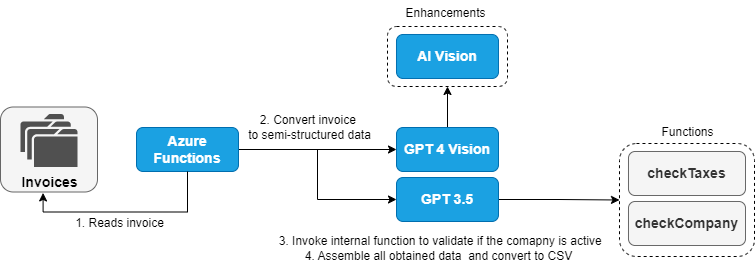

In [ ]:
dadosNf

'Here is the content of the document in JSON format, including the \'Item da Lei 116\' field with the code that best fits the description of the service provided:\n\n```json\n{\n  "numero_nf": "00034181",\n  "data_hora_emissao": "01/04/2024 00:00:00",\n  "codigo_verificacao": "3dcd5845",\n  "prestador": {\n    "razao_social": "MATERA SYSTEMS INFORMATICA SA",\n    "cpf_cnpj": "57.040.040/0001-84",\n    "insc_municipal": "00005604-9",\n    "endereco": "AVENIDA SELMA PARADA (BAILARINA), NO00505 - CONJUNTO 701 ANDAR 7 - BAIRRO JARDIM MADALENA - CEP:13091-605",\n    "municipio": "CAMPINAS",\n    "uf": "SP",\n    "email": "",\n    "telefone": "(19) 37947700"\n  },\n  "tomador": {\n    "razao_social": "SUPERBID PAY INSTITUICAO DE PAGAMENTO LTDA",\n    "cpf_cnpj": "35.084.163/0001-84",\n    "insc_municipal": "00000000-0",\n    "endereco": "AV ENG LUIZ CARLOS BERRINI, N105 - ANDAR 4 - CIDADE MONCOES - CEP:04571-900",\n    "municipio": "SAO PAULO (CAPITAL)",\n    "uf": "SP",\n    "email": "PEDID

In [ ]:
def getCNPJStatus(CNPJ: str):
  CNPJ = CNPJ.replace('.','').replace('-','').replace('/','')
  print(f'Looking for {CNPJ}')
  data = requests.get(f"https://publica.cnpj.ws/cnpj/{CNPJ}")

  data = json.loads(data.text)
  finalResult: dict = {
      "situacao": data['estabelecimento']['situacao_cadastral'],
      "tipoempresa": data['simples']
  }

  if finalResult['tipoempresa'] is None:
    finalResult['tipoempresa'] = 'Lucro presumido'
  else:
    if finalResult['tipoempresa']['simples'] == 'Sim':
      finalResult['tipoempresa'] = 'Simples nacional'
    else:
      finalResult['tipoempresa'] = 'MEI'


  return json.dumps(finalResult)


client = AzureOpenAI(
  azure_endpoint = "https://openaiwestusalb.openai.azure.com/",
  api_key="f3af149c7c724ff88c3bf54eb69d6381",
  api_version="2024-02-15-preview"
)


messages  = [
      {"role":"system","content":"""
        # available tools
        You have the following tools you can invoke depending on user request.
        - getCNPJStatus: when the user asks for their CNPJ status given the CNPJ number.
        - If any JSON data, assimilate into a text description
      """},
      {"role":"user","content":"Please extract the CNPJ from "+dadosNf}
    ]

tools = [
    {
            "type": "function",
            "function": {
                "name": "getCNPJStatus",
                "description": "Show the CNPJ based on the provided number",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "CNPJ": {
                            "type": "string",
                            "description": "CNPJ number",
                        }
                    },
                    "required": ["CNPJ"],
                },
            },
        }
]

completion = client.chat.completions.create(
  model="testgptturbofunc", # model = "deployment_name"
  messages = messages,
  tools=tools,
  tool_choice="auto"
)




response_message = completion.choices[0].message

usage_details['GPT 3.5 Function calling'] = completion.usage.to_dict()



In [ ]:
print(getCNPJStatus('57040040000184'))

Looking for 57040040000184
{"situacao": "Ativa", "tipoempresa": "Lucro presumido"}


In [ ]:
response_message


ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_W6P5ufbAEMcMYwACQ7KzRErB', function=Function(arguments='{"CNPJ":"57040040000184"}', name='getCNPJStatus'), type='function')])

In [ ]:
tool_calls = response_message.tool_calls
tool_calls[0].function.name

'getCNPJStatus'

In [ ]:
if tool_calls:
        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        available_functions = {
            "getCNPJStatus": getCNPJStatus,
        }  # only one function in this example, but you can have multiple
        messages.append(response_message)  # extend conversation with assistant's reply
        # Step 4: send the info for each function call and function response to the model
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            function_response = function_to_call(
                CNPJ=function_args.get("CNPJ")
            )
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                }
            )  # extend conversation with function response
            messages.append(
                {"role":"system","content": dadosNf}
            )
            messages.append(
                {"role":"user","content":"""
                Based on the previous answers and inputs, convert all the company JSON data adding if it is active or not and the type of company: 'simples nacional', 'mei' or 'lucro presumido'.
                If 'Lucro presumido', add the aliquotas in the field: 'aliquotas_validacao' for the company based on its information.
                Expose the following fields:
                  Número da Nota
                  Data e Hora de Emissão
                  Código de Verificação
                  Prestador - Nome/Razão Social
                  Prestador - CPF/CNPJ
                  Prestador - Inscrição Municipal
                  Prestador - Endereço
                  Prestador - Município
                  Prestador - UF
                  Prestador - Telefone
                  Tomador - Nome/Razão Social
                  Tomador - CPF/CNPJ
                  Tomador - Inscrição Municipal
                  Tomador - Endereço
                  Tomador - Município
                  Tomador - UF
                  Tomador - E-mail
                  Tomador - Telefone
                  Discriminação dos Serviços
                  Valor Líquido
                  Valor Total da Nota
                  Deduções Base Cálculo ISSQN
                  Base de Cálculo ISSQN
                  Alíquota ISSQN
                  ISSQN Devido
                  CNAE
                  Descrição da Atividade
                  Serviço
                  PIS
                  COFINS
                  INSS
                  IR
                  CSLL
                  Data de vencimento do ISSQN
                  ATIVA
                  TIPO_EMPRESA
                  ALIQUOTA_VALIDACAO
                  ITEM DA LEI 116
                """}
            )
            messages.append({"role":"user","content": dadosNf})
              # extend conversation with function response
        second_response = client.chat.completions.create(
            model="testgptturbofunc",
            messages=messages,
            response_format={ "type": "json_object" }
        )  # get a new response from the model where it can see the function response

        usage_details['GPT 3.5 Completion'] = second_response.usage.to_dict()

Looking for 57040040000184


In [ ]:
sec_response_message = second_response.choices[0].message.content
sec_response_message

'{\n  "Cabecalho": {\n    "Numero_da_Nota": "00034181",\n    "Data_e_Hora_de_Emissao": "01/04/2024 00:00:00",\n    "Codigo_de_Verificacao": "3dcd5845"\n  },\n  "Prestador_de_Servicos": {\n    "Nome_Razao_Social": "MATERA SYSTEMS INFORMATICA SA",\n    "CPF_CNPJ": "57.040.040/0001-84",\n    "Inscricao_Municipal": "00005604-9",\n    "Endereco": "AVENIDA SELMA PARADA (BAILARINA), NO00505 - CONJUNTO 701 ANDAR 7 - BAIRRO JARDIM MADALENA - CEP:13091-605",\n    "Municipio": "CAMPINAS",\n    "UF": "SP",\n    "Telefone": "(19) 37947700",\n    "ATIVA": "Ativa",\n    "TIPO_EMPRESA": "Lucro presumido",\n    "ALIQUOTA_VALIDACAO": {\n      "PIS": "R$ 498,27",\n      "COFINS": "R$ 2.299,73",\n      "INSS": "R$ 0,00",\n      "IR": "R$ 1.149,86",\n      "CSLL": "R$ 766,58"\n    }\n  },\n  "Tomador_de_Servicos": {\n    "Nome_Razao_Social": "SUPERBID PAY INSTITUICAO DE PAGAMENTO LTDA",\n    "CPF_CNPJ": "35.084.163/0001-84",\n    "Inscricao_Municipal": "00000000-0",\n    "Endereco": "AV ENG LUIZ CARLOS BER

In [ ]:
result = json.loads(sec_response_message)

In [ ]:
result

{'Cabecalho': {'Numero_da_Nota': '00034181',
  'Data_e_Hora_de_Emissao': '01/04/2024 00:00:00',
  'Codigo_de_Verificacao': '3dcd5845'},
 'Prestador_de_Servicos': {'Nome_Razao_Social': 'MATERA SYSTEMS INFORMATICA SA',
  'CPF_CNPJ': '57.040.040/0001-84',
  'Inscricao_Municipal': '00005604-9',
  'Endereco': 'AVENIDA SELMA PARADA (BAILARINA), NO00505 - CONJUNTO 701 ANDAR 7 - BAIRRO JARDIM MADALENA - CEP:13091-605',
  'Municipio': 'CAMPINAS',
  'UF': 'SP',
  'Telefone': '(19) 37947700',
  'ATIVA': 'Ativa',
  'TIPO_EMPRESA': 'Lucro presumido',
  'ALIQUOTA_VALIDACAO': {'PIS': 'R$ 498,27',
   'COFINS': 'R$ 2.299,73',
   'INSS': 'R$ 0,00',
   'IR': 'R$ 1.149,86',
   'CSLL': 'R$ 766,58'}},
 'Tomador_de_Servicos': {'Nome_Razao_Social': 'SUPERBID PAY INSTITUICAO DE PAGAMENTO LTDA',
  'CPF_CNPJ': '35.084.163/0001-84',
  'Inscricao_Municipal': '00000000-0',
  'Endereco': 'AV ENG LUIZ CARLOS BERRINI, N105 - ANDAR 4 - CIDADE MONCOES - CEP:04571-900',
  'Municipio': 'SAO PAULO (CAPITAL)',
  'UF': 'SP',

In [ ]:
usage_details

{'GPT4 Vision': {'prompt_tokens': 2216,
  'completion_tokens': 1043,
  'total_tokens': 3259},
 'GPT 3.5 Function calling': {'completion_tokens': 22,
  'prompt_tokens': 1164,
  'total_tokens': 1186},
 'GPT 3.5 Completion': {'completion_tokens': 1088,
  'prompt_tokens': 3621,
  'total_tokens': 4709}}

# Final result (2st approach: Data formatting only)

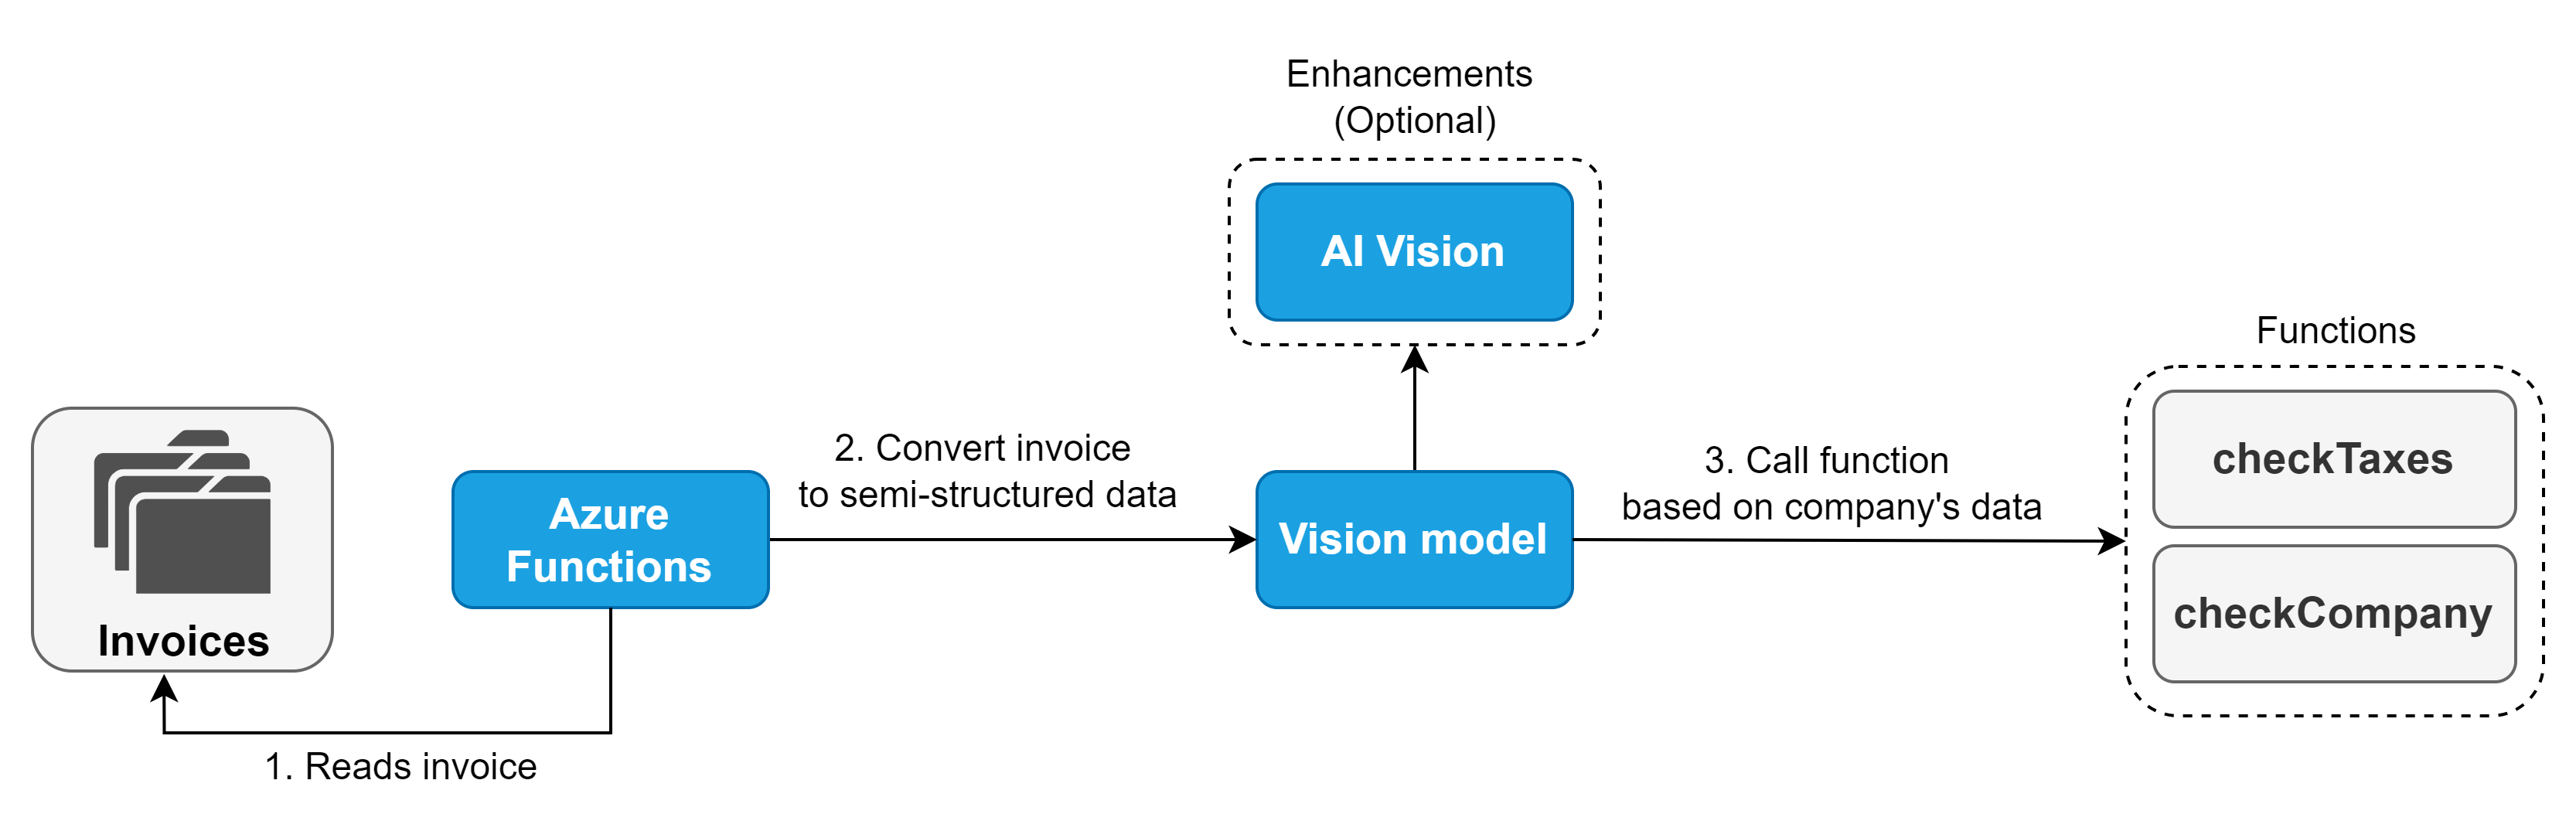

In [63]:
completionFormated: list[dict] = []

for completion in completions_results:
    print(f"Converting {completion['model']} {completion['file_name']}")

    try:
        jsonResult: dict = json.loads(completion['completionResult'])
    except:
        jsonResult: dict = {}

    result = {
        'model': completion['model'],
        'file_name': completion['file_name'],
        
    }

    result.update(jsonResult)

    completionFormated.append(result)


Converting gpt4Vision NF_001
Converting gpt4Vision NF_002
Converting gpt4Vision NF_003
Converting gpt4Vision NF_004
Converting gpt4Vision NF_005
Converting gpt4Vision NF_34181
Converting gpt4o NF_001
Converting gpt4o NF_002
Converting gpt4o NF_003
Converting gpt4o NF_004
Converting gpt4o NF_005
Converting gpt4o NF_34181
Converting gemini NF_001
Converting gemini NF_002
Converting gemini NF_003
Converting gemini NF_004
Converting gemini NF_005
Converting gemini NF_34181


In [64]:
completionFormated

[{'model': 'gpt4Vision',
  'file_name': 'NF_001',
  'numero_nf': '202400000001880',
  'data_hora_emissao': '03/05/2024',
  'codigo_verificacao': 'c7447d56',
  'prestador': {'razao_social': 'DESKBEE LTDA',
   'cpf_cnpj': '09.591.453/0001-04',
   'insc_municipal': '51806827',
   'endereco': 'R BARONEZA DO GRAVATAI, 137 Conjunto 307 - CIDADE BAIXA',
   'municipio': 'Porto Alegre',
   'uf': 'RS',
   'email': 'financeiro@inventsys.com.br',
   'telefone': '(51) 3907-7999'},
  'tomador': {'razao_social': 'SBPAR PARTICIPACOES S/A',
   'cpf_cnpj': '09.465.368/0001-08',
   'insc_municipal': '',
   'endereco': 'R HENRIQUE MONTEIRO, 125 ANDAR 2 PARTE',
   'municipio': 'São Paulo',
   'uf': 'SP',
   'email': 'jhon.silva@superbid.net',
   'telefone': '(114) 9509-6460'},
  'discrim_servico': 'INTEGRAÇÕES_Salas de Reunião Google e/ou Outlook - STARTER',
  'vlr_liquido': 'R$ 190,00',
  'vlr_tot_nf': 'R$ 190,00',
  'deduc_base_calc_issqn': 'R$ 0,00',
  'base_calculo_issqn': 'R$ 190,00',
  'aliq_issqn': 

In [65]:
import pandas as pd

df = pd.DataFrame(completionFormated)

In [66]:
df.sort_values(by=["file_name"])

,model,file_name,numero_nf,data_hora_emissao,codigo_verificacao,prestador,tomador,discrim_servico,vlr_liquido,vlr_tot_nf,...,cnae,desc_ativ,servico,pis,cofins,inss,ir,csll,data_venc_issqn,item_lei_116
0,gpt4Vision,NF_001,202400000001880,03/05/2024,c7447d56,"{'razao_social': 'DESKBEE LTDA', 'cpf_cnpj': '...","{'razao_social': 'SBPAR PARTICIPACOES S/A', 'c...",INTEGRAÇÕES_Salas de Reunião Google e/ou Outlo...,"R$ 190,00","R$ 190,00",...,10500100,Serviços de integração de sistemas de comunica...,1.05,Retenção de PIS,Retenção de Cofins,Retenção de INSS,Retenção de IRPJ,Retenção de CSLL,,10.01
12,gemini,NF_001,202400000001880,03/05/2024,c7447d56,"{'razao_social': 'DESKBE LTDA', 'cpf_cnpj': '0...","{'razao_social': 'SBPAR PARTICIPACOES S/A', 'c...",INTEGRAÇÕES_Salas de Reunião Google e/ou Outlo...,"190,00","190,00",...,,,,,,,,,,1.05
6,gpt4o,NF_001,202400000001880,03/05/2024,c7447d56,"{'razao_social': 'DESKBEE LTDA', 'cpf_cnpj': '...","{'razao_social': 'SBPAR PARTICIPACOES S/A', 'c...",INTEGRAÇÕES_Salas de Reunião Google e/ou Outlo...,"R$ 190,00","R$ 190,00",...,4314902,Tributação no município,10500100 / Subitem da lista de serviços: 1.05,,,,,,,1.05
1,gpt4Vision,NF_002,2024000,03/05/2024 07:31:00,2WOZ-AM5N,{'razao_social': 'EIZIEMANN INFORMATICA SOCIED...,"{'razao_social': 'SUPERBID WEBSERVICES LTDA', ...","Serviços prestados na Área de informatica, Rea...","22.268,56","23.727,82",...,620400000,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,0101,"154,23","711,83","0,00","355,92","237,28",05/2024,1.01
13,gemini,NF_002,00000009,2024-05-03T07:31:00-03:00,2WQZ-AM5N,{'razao_social': 'EIZIEMANN INFORMATICA SOCIED...,"{'razao_social': 'SUPERBID WEBSERVICES LTDA', ...",0101 - ANÁLISE E DESENVOLVIMENTO DE SISTEMAS C...,"22.268,56","23.727,82",...,620400000,"Serviços prestados na Área de informatica, Rea...",0101,"154,23","711,83","0,00","355,92","237,28",None,0101
7,gpt4o,NF_002,2024000,03/05/2024 07:31:00,2WQZ-AM5N,{'razao_social': 'EIZEMANN INFORMATICA SOCIEDA...,"{'razao_social': 'SUPERBID WEBSERVICES LTDA', ...","Serviços prestados na Área de informática, Rea...","22.268,56","23.727,82",...,620400000,0101 - ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,Análise e Desenvolvimento de Sistemas,"154,23","711,83","0,00","355,92","237,28",03/05/2024 07:31:00,1.03
14,gemini,NF_003,00000088,06/05/2024 10:21:21,6RIX-CEKY,{'razao_social': 'BRUNO DO CARMO PALERMO LIMIT...,"{'razao_social': 'SUPERBID WEBSERVICES LTDA', ...",Apoio no desenvolvimento de projetos de tecnol...,"18.400,00","18.400,00",...,----,----,01.07.01 - suporte técnico em informática,----,----,----,----,----,----,01.07.01
8,gpt4o,NF_003,00000088,06/05/2024 10:21:21,6RIX-CEKY,{'razao_social': 'BRUNO DO CARMO PALERMO LIMIT...,"{'razao_social': 'SUPERBID WEBSERVICES LTDA', ...",Apoio no desenvolvimento de projetos de tecnol...,"0,00","18.400,00",...,-----,01.07.01 - suporte técnico em informática,-----,-----,-----,-----,-----,-----,-----,1.07
2,gpt4Vision,NF_003,00000088,06/05/2024 10:21:21,6RIX-CEKY,{'razao_social': 'BRUNO DO CARMO PALERMO LIMIT...,"{'razao_social': 'SUPERBID WEBSERVICES LTDA', ...",Apoio no desenvolvimento de projetos de tecnol...,"R$ 18.400,00","R$ 18.400,00",...,,suporte técnico em informática,01.07.01,,,,,,,1.07
9,gpt4o,NF_004,100,05/05/2024 13:02:41,IZVEBBOXZ,{'razao_social': '3DR SERVICOS EM TECNOLOGIA D...,"{'razao_social': 'SUPERBID WEBSERVICES LTDA', ...",Desenvolvimento e licenciamento de programas d...,8000.0,8000.0,...,1.07.00 / 1869,SUPORTE TÉCNICO EM INFORMÁTICA,Desenvolvimento e licenciamento de programas d...,0.0,0.0,0.0,0.0,0.0,,1.05


In [ ]:
finalDataset: dict = json.loads(dadosNf)

checkCompany: dict = json.loads(getCNPJStatus(finalDataset['prestador']['cpf_cnpj']))
finalDataset['situacao'], finalDataset['tipo_empresa'] = checkCompany['situacao'],checkCompany['tipoempresa']

Looking for 57040040000184


In [ ]:
print(json.dumps(finalDataset))

{"numero_nf": "00034181", "data_hora_emissao": "01/04/2024 00:00:00", "codigo_verificacao": "3dcd5845", "prestador": {"razao_social": "MATERIA SYSTEMS INFORMATICA SA", "cpf_cnpj": "57.040.040/0001-84", "insc_municipal": "00005604-9", "endereco": "AVENIDA SELMA PARADA (BAILARINA), N000505 - CONJUNTO 701 ANDAR 7 - BAIRRO JARDIM MADALENA - CEP:13091-605", "municipio": "CAMPINAS", "uf": "SP", "email": "", "telefone": "(19) 37947700"}, "tomador": {"razao_social": "SUPERBID PAY INSTITUICAO DE PAGAMENTO LTDA", "cpf_cnpj": "35.084.163/0001-84", "insc_municipal": "00000000-0", "endereco": "AV ENG LUIZ CARLOS BERRINI, N105 - ANDAR 4 - CIDADE MONCOES - CEP:04571-900", "municipio": "SAO PAULO(CAPITAL)", "uf": "SP", "email": "PEDIDOS@SUPERBID.NET;COMPRAS@SUPERBID.NET;", "telefone": "(11) 49509646"}, "discrim_servico": "NF SERA QUITADA MEDIANTE PAGAMENTO DO BOLETO ANEXO VENCIMENTO: 15.04.2024, VALOR LIQUIDO: R 71.943,07 APOS VENCIMENTO ACRESCENTAR MULTA DE 2 SOBRE O VALOR DEVIDO E JUROS MORATORIOS D